# Segmentação Semântica com dados sísmicos

Adaptado do artigo:

[A Machine Learning Benchmark for Facies Classification](https://arxiv.org/abs/1901.07659), por *Yazeed Alaudah, Patrycja Michalowicz, Motaz Alfarraj, Ghassan AlRegib*

In [6]:
# @title Importando bibliotecas / módulos
import collections
import numpy
import os
import PIL
import random
import torch
from tqdm.notebook import tqdm

torch.manual_seed(2025)

import matplotlib.pyplot as plt

## Netherlands F3 block

O bloco F3 da Holanda, no contexto do trabalho de Alaudah e colaboradores (referência necessária para o ano), é um conjunto de dados sísmicos 3D de alta qualidade e bem anotado, tornando-se um recurso valioso para pesquisadores que trabalham com interpretação sísmica e aprendizado de máquina.

Aqui estão alguns pontos-chave sobre o bloco F3 da Holanda usado por Alaudah e colaboradores:

*   Localização: Mar do Norte, Holanda
*   Data de aquisição: 1987 (pode ser um fator limitante devido à tecnologia de levantamento sísmico mais antiga)
*   Tipo de levantamento: Levantamento sísmico convencional (pode ter resolução inferior em comparação com levantamentos mais recentes)
*    Área de cobertura: Aproximadamente 384 quilômetros quadrados  
*    Resolução: Considerada alta para a época da aquisição
*    Anotação: Interpretações manuais de horizontes e falhas (permite o treinamento de modelos para tarefas de segmentação sísmica)
*     Disponibilidade pública: Sim (verifique a fonte original para detalhes de acesso)

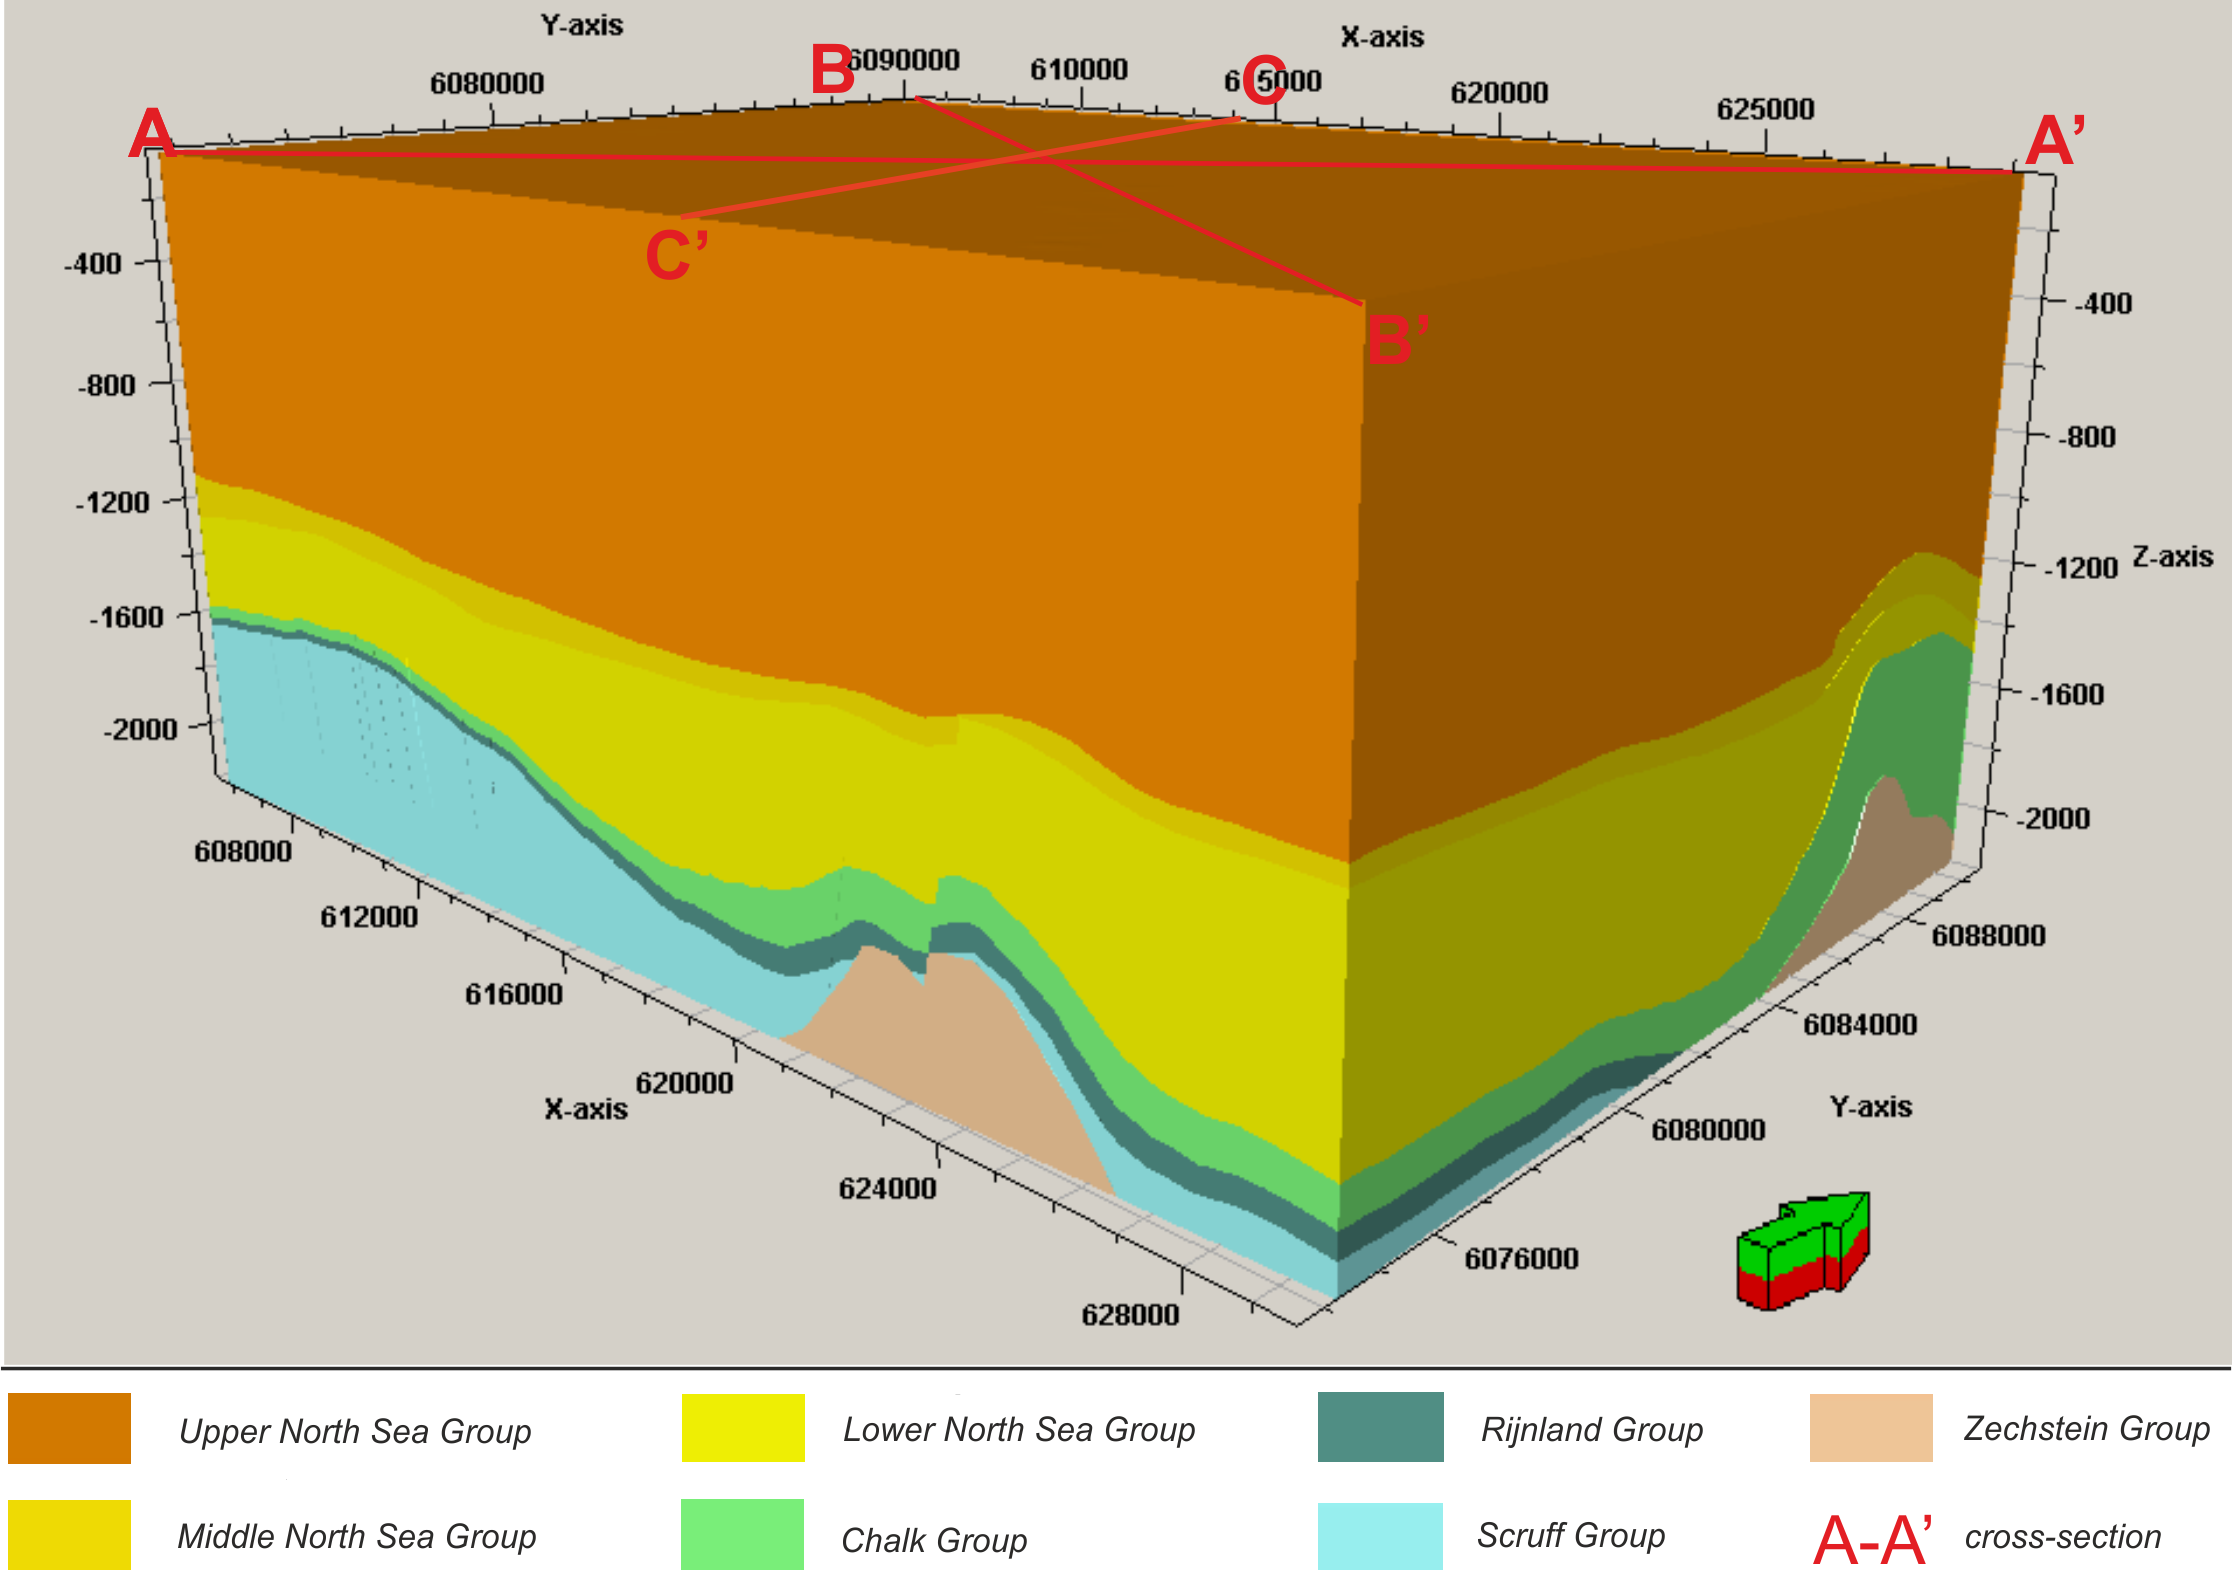


In [8]:
#@title Classe para base de dados
# https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset
# https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataloader
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

class F3BlockDataset(torch.utils.data.Dataset):
    """
    Data loader for the section-based strategy for the NL dataset.

    Loads seismic and label data from the specified dataset split (train, valid, test1, or test2),
    optionally applies data augmentation, and transforms data into PyTorch tensors for training.
    Provides methods for decoding segmentation masks, accessing class information, and generating K-fold splits.
    """
    def __init__(self, split='train', subset=None, channel_delta=0, data_folder='data_NL', is_transform=True, augmentations=None):
        """
        Initializes the dataset.

        Args:
            split (str): Dataset split to load ('train', 'valid', 'test1', or 'test2').
            channel_delta (int): Number of adjacent channels to include in input data (0 or >0).
            data_folder (str): Path to the dataset directory.
            is_transform (bool): Whether to apply data normalization and channel expansions.
            augmentations (callable, optional): Augmentation function to apply to data.
        """
        self.split = split
        self.c_delta = channel_delta
        self.data_folder = data_folder
        self.is_transform = is_transform
        self.augmentations = augmentations
        self.n_classes = 6
        self.mean = 0.0009996710808862074
        self.stdev = 0.20976548783479299
        self.sections = collections.defaultdict(list)

        if self.split in ['train', 'valid', 'train_valid']:
            # Normal train/valid mode
            self.seismic = numpy.load(os.path.join(self.data_folder,'train','train_seismic.npy'))
            self.labels  = numpy.load(os.path.join(self.data_folder,'train','train_labels.npy'))
        elif self.split in ['test1']:
            self.seismic = numpy.load(os.path.join(self.data_folder,'test_once','test1_seismic.npy'))
            self.labels  = numpy.load(os.path.join(self.data_folder,'test_once','test1_labels.npy'))
        elif self.split in ['test2']:
            self.seismic = numpy.load(os.path.join(self.data_folder,'test_once','test2_seismic.npy'))
            self.labels  = numpy.load(os.path.join(self.data_folder,'test_once','test2_labels.npy'))
        else:
            raise ValueError(f'Unknown split: "{self.split}". Should be one of ["train", "valid", "train_val", "test1", "test2"]')

        if subset is None:
            irange, crange, depth = self.labels.shape
            i_list, c_list  = list(range(irange)), list(range(crange))
            i_list  = ['i_'+str(inline)    for inline    in i_list]
            c_list  = ['x_'+str(crossline) for crossline in c_list]
            self.sections[split] = i_list + c_list
        else:
            self.sections[split] = subset

    def __len__(self):
        """
        Returns the total number of sections in the dataset split.
        """
        return len(self.sections[self.split])

    def __getitem__(self, index):
        """
        Retrieves a single data sample (seismic image and label) at the specified index.

        Expected dataset shape: (401, 701, 255)
            "num_inlines": 401
            "num_crosslines": 701
            "num_time_depth": 255

        Args:
            index (int): Index of the sample to retrieve.

        Returns:
            tuple: A tuple containing the seismic image (torch.Tensor) and label mask (torch.Tensor).
        """
        section_name = self.sections[self.split][index]
        direction, number = section_name.split(sep='_')
        slice_number = int(number)

        if direction == 'i':
            try:
                lbl = self.labels[slice_number,:,:].transpose((1,0))
                if self.c_delta == 0:
                    img = self.seismic[slice_number,:,:].transpose((1,0))
                elif self.c_delta > 0:
                    img = self.seismic[max(0,slice_number-self.c_delta):min(self.seismic.shape[0],slice_number+self.c_delta+1),:,:]
                    img = numpy.stack([img[0,:,:], img[img.shape[0]//2,:,:], img[-1,:,:]]).transpose((0,2,1))
                else:
                    raise RuntimeError(f'INLINE - No implementation for self.c_delta={self.c_delta}')
            except:
                raise RuntimeError(f'INLINE - Batch {index}: \t section [{section_name}]={direction}_{slice_number} \t {self.seismic[slice_number,:,:].shape} {self.seismic[slice_number-self.c_delta:slice_number+self.c_delta+1,:,:].shape}')
        elif direction == 'x':
            try:
                lbl = self.labels[:,slice_number,:].transpose((1,0))
                if self.c_delta == 0:
                    img = self.seismic[:,slice_number,:].transpose((1,0))
                elif self.c_delta > 0:
                    img = self.seismic[:,max(0,slice_number-self.c_delta):min(self.seismic.shape[1],slice_number+self.c_delta+1),:]
                    img = numpy.stack([img[:,0,:], img[:,img.shape[1]//2,:], img[:,-1,:]]).transpose((0,2,1))
                else:
                    raise RuntimeError(f'CROSSLINE - No implementation for self.c_delta={self.c_delta}')
            except:
                raise RuntimeError(f'CROSSLINE - Batch {index}: \t section [{section_name}]={direction}_{slice_number} \t {self.seismic[:,slice_number,:].shape} {self.seismic[:,slice_number-self.c_delta:slice_number+self.c_delta+1,:].shape}')
        else:
            raise RuntimeError(f'Seismic direction does not correspond to INLINE (I) or CROSSLINE (X)')

        if self.augmentations is not None:
            img, lbl = self.augmentations(img, lbl)

        if self.is_transform:
            img, lbl = self.transform(img, lbl)
        return img, lbl

    def decode_segmap(self, label_mask, plot=False, save_name=None):
        """
        Decodes a segmentation label mask into a color image.

        Args:
            label_mask (numpy.ndarray): An array of integer class labels.
            plot (bool, optional): Whether to display the decoded image.
            save_name (str, optional): Name to save the decoded image if provided.

        Returns:
            numpy.ndarray: The decoded color image array, or None if plot=True.
        """
        label_colours = self.get_seismic_colors()
        r = label_mask.copy()
        g = label_mask.copy()
        b = label_mask.copy()
        for ll in range(0, self.n_classes):
            r[label_mask == ll] = label_colours[ll, 0]
            g[label_mask == ll] = label_colours[ll, 1]
            b[label_mask == ll] = label_colours[ll, 2]
        rgb = numpy.zeros((label_mask.shape[0], label_mask.shape[1], 3))
        rgb[:, :, 0] = r / 255.0
        rgb[:, :, 1] = g / 255.0
        rgb[:, :, 2] = b / 255.0
        plt.tight_layout()
        if save_name is not None:
            plt.imshow(rgb)
            plt.savefig(save_name)
        if plot:
            plt.imshow(rgb)
            plt.show()
        else:
            return rgb

    def transform(self, img, lbl):
        """
        Applies data normalization and channel expansions to prepare data for PyTorch.

        Args:
            img (numpy.ndarray): Image data.
            lbl (numpy.ndarray): Label data.

        Returns:
            img (torch.Tensor): Transformed image data.
            lbl (torch.Tensor): Transformed label data.
        """
        img = (img - self.mean)/self.stdev

        # to be in the BxCxHxW that PyTorch uses:
        if len(img.shape) == 2:
            img = numpy.expand_dims(img,0)
        if len(lbl.shape) == 2:
            lbl = numpy.expand_dims(lbl,0)

        img = torch.from_numpy(img).float()
        lbl = torch.from_numpy(lbl).long()

        return img, lbl

    def get_class_names(self):
        """
        Returns a list of class names corresponding to the segmentation labels.
        """
        return ['upper_ns', 'middle_ns', 'lower_ns', 'rijnland_chalk', 'scruff', 'zechstein']

    def get_class_weights(self):
        """
        Returns a list of class weights, potentially for addressing class imbalance.
        Alaudah paper: [0.7151, 0.8811, 0.5156, 0.9346, 0.9683, 0.9852]
        """
        bin_count = numpy.bincount(self.labels.flatten())
        return 1. - (bin_count / numpy.sum(bin_count))

    def get_prediction_horizons(self):
        """
        Returns a list of depth indices for prediction horizons.
        """
        return [0, 99, 149, 299, 399, 499]

    def get_seismic_colors(self):
        """
        Returns an array of RGB color codes for visualizing seismic data.
        """
        return numpy.asarray([ [69,117,180], [145,191,219], [224,243,248], [254,224,144], [252,141,89], [215,48,39]])

    @staticmethod
    def split_train_val(data_folder, loader_type='section', per_val=0.1):
        """
            Splits inline and crossline sections for training and validation.

            This function splits inline and crossline sections from a seismic dataset for
            training and validation purposes. It accepts various arguments to control the
            splitting process:

            Args:
                data_folder (str): Path to the data folder containing the dataset.
                loader_type (str, optional): Type of loader to be used ('section' or 'horizon'). Defaults to 'section'.
                per_val (float, optional): Proportion of data to be used for validation. Defaults to 0.1.

            Returns:
                None

            Raises:
                ValueError: If `loader_type` is not 'section' or 'horizon'.

            Saves:
                - Three text files in the `data_folder/splits` directory:
                    - `loader_type_train_val.txt`: List of all sections for both training and validation.
                    - `loader_type_train.txt`: List of sections used for training.
                    - `loader_type_val.txt`: List of sections used for validation.
        """
        from sklearn.model_selection import train_test_split
        labels = numpy.load(os.path.join(data_folder, 'train', 'train_labels.npy'))
        irange, crange, depth = labels.shape

        i_list = list(range(irange))
        i_list = ['i_'+str(inline) for inline in i_list]

        c_list = list(range(crange))
        c_list = ['x_'+str(crossline) for crossline in c_list]

        # create train and validation splits:
        list_train_i, list_valid_i = train_test_split(i_list, test_size=per_val, shuffle=False, random_state=0)
        list_train_c, list_valid_c = train_test_split(c_list, test_size=per_val, shuffle=False, random_state=0)

        return (list_train_i + list_train_c, list_valid_i + list_valid_c)

## Exercício 1

Dadas as classes definidas acima, preencha os células abaixo, instanciando objetos da seguinte maneira:

* Separe o conjunto de treinamento em dois subconjuntos disjuntos (treino com 90% dos dados e validação com o restante 10%).
* Crie objetos da classe `F3BlockDataset` para os subconjuntos de treino e validação. Forneça somente os paramêtros `split`, `subset`, e `data_folder`. Não utilizaremos *data augmentation* por enquanto.
* Crie o gerenciador de *batches* (`torch.utils.data.DataLoader`) para que as amostras de sua base de dados possam ser devidamente carregadas.

In [9]:
# @title Separando Treino e Validação

# Na Tatu, os dados já estão salvos no seguinte diretório:
data_path = '/pgeoprj2/ciag2024/dados/f3'

# TODO: separar treino e validação
train_subset, valid_subset = ...

In [10]:
# @title Definindo seus Datasets

# TODO: definir seus datasets'
train_dataset = ...
valid_dataset = ...

In [11]:
#@title Definindo o carregador do Dataset
class CustomSampler(torch.utils.data.Sampler):
    def __init__(self, sample_list):
        self.counter = 0
        self.sample_list = sample_list

    def __iter__(self):
        mode = 'i' if (self.counter % 2 == 0) else 'x'
        self.counter += 1
        self.indices = [idx for (idx, name) in enumerate(self.sample_list) if mode in name]
        return (self.indices[i] for i in torch.randperm(len(self.indices)))

    def __len__(self):
        mode = 'i' if (self.counter % 2 == 0) else 'x'
        indices = [idx for (idx, name) in enumerate(self.sample_list) if mode in name]
        return len(indices)

# https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
# TODO: definir seus dataloaders
train_dataloader = ...
valid_dataloader = ...

## DeconvNet: Deconvolutional Network

DeconvNet, também conhecido como rede deconvolucional, é uma arquitetura de rede neural artificial (RNA) inspirada na rede convolucional (CNN). Enquanto as CNNs são usadas para extrair recursos de imagens e realizar tarefas como classificação e reconhecimento de objetos, as DeconvNets são usadas para gerar imagens a partir de representações de alto nível.

As DeconvNets invertem o processo de convolução usado em CNNs. Em vez de usar filtros convolucionais para reduzir a dimensionalidade das entradas, as DeconvNets usam filtros de deconvolução para aumentar a dimensionalidade das entradas. Isso significa que elas podem transformar representações compactas de alto nível em imagens com alta resolução espacial.

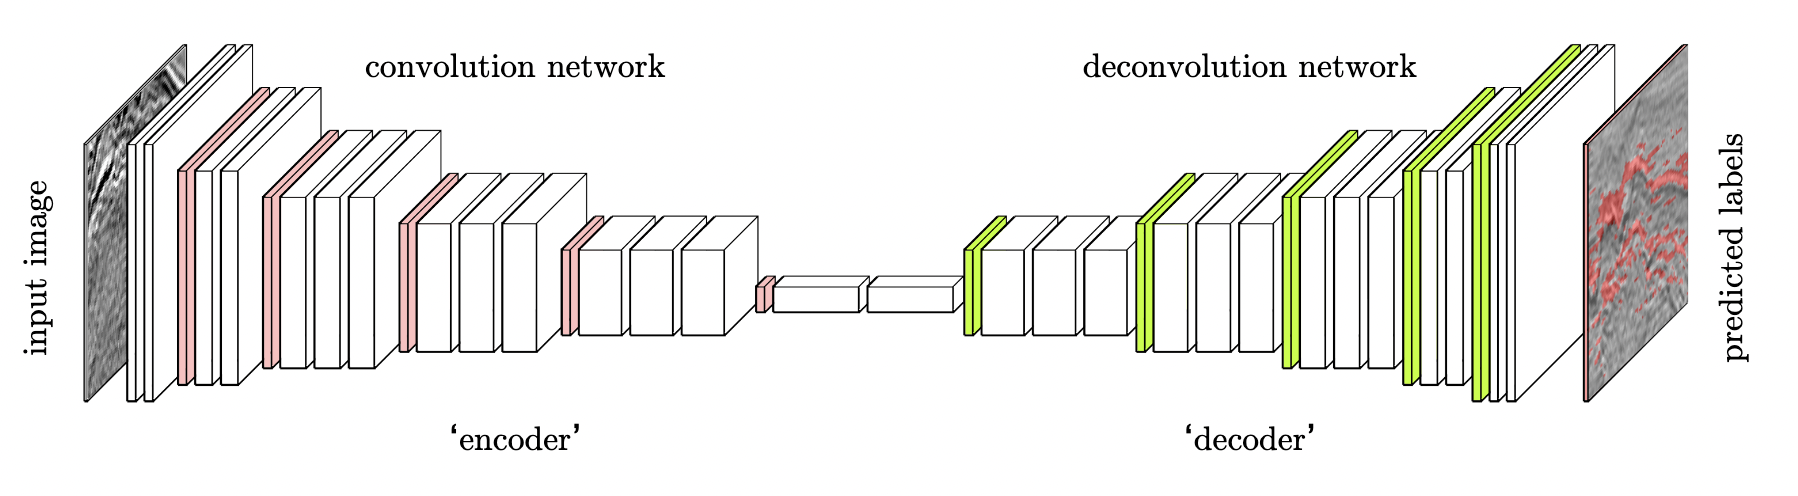

In [12]:
class DeconvNet(torch.nn.Module):
    """
    DeconvNet model for semantic segmentation, inspired by VGG16 architecture.

    It consists of a contracting path (similar to VGG16) followed by an
    expanding path with unpooling and deconvolution layers.
    """
    def __init__(self, n_channels=1, n_classes=6):
        """
        Initializes the DeconvNet model.

        Args:
            n_channels (int, optional): Number of input channels (default: 1).
            n_classes (int, optional): Number of output classes (default: 6).
        """
        super(DeconvNet, self).__init__()
        self.n_classes = n_classes
        self.unpool = torch.nn.MaxUnpool2d(2, stride=2)

        ### Contracting path (similar to VGG16) ###

        self.conv_block1 = torch.nn.Sequential(
            # conv1_1
            torch.nn.Conv2d(in_channels=n_channels, out_channels=64, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True),
            torch.nn.ReLU(inplace=True),
            # conv1_2
            torch.nn.Conv2d(64, 64, 3, padding=1),
            torch.nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True),
            torch.nn.ReLU(inplace=True),
            # pool1
            torch.nn.MaxPool2d(2, stride=2, return_indices=True, ceil_mode=True), )
        # it returns outputs and pool_indices_1

        # 48*48
        self.conv_block2 = torch.nn.Sequential(
            # conv2_1
            torch.nn.Conv2d(64, 128, 3, padding=1),
            torch.nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True),
            torch.nn.ReLU(inplace=True),
            # conv2_2
            torch.nn.Conv2d(128, 128, 3, padding=1),
            torch.nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True),
            torch.nn.ReLU(inplace=True),
            # pool2
            torch.nn.MaxPool2d(2, stride=2, return_indices=True, ceil_mode=True), )
        # it returns outputs and pool_indices_2

        # 24*24
        self.conv_block3 = torch.nn.Sequential(
            # conv3_1
            torch.nn.Conv2d(128, 256, 3, padding=1),
            torch.nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True),
            torch.nn.ReLU(inplace=True),
            # conv3_2
            torch.nn.Conv2d(256, 256, 3, padding=1),
            torch.nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True),
            torch.nn.ReLU(inplace=True),
            # conv3_3
            torch.nn.Conv2d(256, 256, 3, padding=1),
            torch.nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True),
            torch.nn.ReLU(inplace=True),
            # pool3
            torch.nn.MaxPool2d(2, stride=2, return_indices=True, ceil_mode=True), )
        # it returns outputs and pool_indices_3

        # 12*12
        self.conv_block4 = torch.nn.Sequential(
            # conv4_1
            torch.nn.Conv2d(256, 512, 3, padding=1),
            torch.nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True),
            torch.nn.ReLU(inplace=True),
            # conv4_2
            torch.nn.Conv2d(512, 512, 3, padding=1),
            torch.nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True),
            torch.nn.ReLU(inplace=True),
            # conv4_3
            torch.nn.Conv2d(512, 512, 3, padding=1),
            torch.nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True),
            torch.nn.ReLU(inplace=True),
            # pool4
            torch.nn.MaxPool2d(2, stride=2, return_indices=True, ceil_mode=True), )
        # it returns outputs and pool_indices_4

        # 6*6
        self.conv_block5 = torch.nn.Sequential(
            # conv5_1
            torch.nn.Conv2d(512, 512, 3, padding=1),
            torch.nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True),
            torch.nn.ReLU(inplace=True),
            # conv5_2
            torch.nn.Conv2d(512, 512, 3, padding=1),
            torch.nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True),
            torch.nn.ReLU(inplace=True),
            # conv5_3
            torch.nn.Conv2d(512, 512, 3, padding=1),
            torch.nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True),
            torch.nn.ReLU(inplace=True),
            # pool5
            torch.nn.MaxPool2d(2, stride=2, return_indices=True, ceil_mode=True), )
        # it returns outputs and pool_indices_5

        # 3*3
        self.conv_block6 = torch.nn.Sequential(
            # fc6
            torch.nn.Conv2d(512, 4096, 3),
            # set the filter size and nor padding to make output into 1*1
            torch.nn.BatchNorm2d(4096, eps=1e-05, momentum=0.1, affine=True),
            torch.nn.ReLU(inplace=True), )

        # 1*1
        self.conv_block7 = torch.nn.Sequential(

            # fc7
            torch.nn.Conv2d(4096, 4096, 1),
            # set the filter size to make output into 1*1
            torch.nn.BatchNorm2d(4096, eps=1e-05, momentum=0.1, affine=True),
            torch.nn.ReLU(inplace=True), )

        ### Expanding path ###

        self.deconv_block8 = torch.nn.Sequential(
            # fc6-deconv
            torch.nn.ConvTranspose2d(4096, 512, 3, stride=1),
            torch.nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True),
            torch.nn.ReLU(inplace=True), )

        # 3*3
        self.unpool_block9 = torch.nn.Sequential(

            # unpool5
            torch.nn.MaxUnpool2d(2, stride=2), )
        # usage unpool(output, indices)

        # 6*6
        self.deconv_block10 = torch.nn.Sequential(
            # deconv5_1
            torch.nn.ConvTranspose2d(512, 512, 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True),
            torch.nn.ReLU(inplace=True),
            # deconv5_2
            torch.nn.ConvTranspose2d(512, 512, 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True),
            torch.nn.ReLU(inplace=True),
            # deconv5_3
            torch.nn.ConvTranspose2d(512, 512, 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True),
            torch.nn.ReLU(inplace=True), )

        self.unpool_block11 = torch.nn.Sequential(
            # unpool4
            torch.nn.MaxUnpool2d(2, stride=2), )

        # 12*12
        self.deconv_block12 = torch.nn.Sequential(
            # deconv4_1
            torch.nn.ConvTranspose2d(512, 512, 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True),
            torch.nn.ReLU(inplace=True),
            # deconv4_2
            torch.nn.ConvTranspose2d(512, 512, 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True),
            torch.nn.ReLU(inplace=True),
            # deconv4_3
            torch.nn.ConvTranspose2d(512, 256, 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True),
            torch.nn.ReLU(inplace=True), )

        self.unpool_block13 = torch.nn.Sequential(
            # unpool3
            torch.nn.MaxUnpool2d(2, stride=2), )

        # 24*24
        self.deconv_block14 = torch.nn.Sequential(
            # deconv3_1
            torch.nn.ConvTranspose2d(256, 256, 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True),
            torch.nn.ReLU(inplace=True),
            # deconv3_2
            torch.nn.ConvTranspose2d(256, 256, 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True),
            torch.nn.ReLU(inplace=True),
            # deconv3_3
            torch.nn.ConvTranspose2d(256, 128, 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True),
            torch.nn.ReLU(inplace=True), )

        self.unpool_block15 = torch.nn.Sequential(
            # unpool2
            torch.nn.MaxUnpool2d(2, stride=2), )

        # 48*48
        self.deconv_block16 = torch.nn.Sequential(
            # deconv2_1
            torch.nn.ConvTranspose2d(128, 128, 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True),
            torch.nn.ReLU(inplace=True),
            # deconv2_2
            torch.nn.ConvTranspose2d(128, 64, 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True),
            torch.nn.ReLU(inplace=True), )

        self.unpool_block17 = torch.nn.Sequential(
            # unpool1
            torch.nn.MaxUnpool2d(2, stride=2), )

        # 96*96
        self.deconv_block18 = torch.nn.Sequential(
            # deconv1_1
            torch.nn.ConvTranspose2d(64, 64, 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True),
            torch.nn.ReLU(inplace=True),
            # deconv1_2
            torch.nn.ConvTranspose2d(64, 64, 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True),
            torch.nn.ReLU(inplace=True), )

        ### Final segmentation layer ###

        self.seg_score19 = torch.nn.Sequential(
            # seg-score
            torch.nn.Conv2d(64, self.n_classes, 1), )


    def forward(self, x):
        """
        Forward pass of the DeconvNet model.

        Args:
            x (torch.Tensor): Input tensor of shape (N, C, H, W).

        Returns:
            torch.Tensor: Output tensor of shape (N, n_classes, H, W) containing segmentation predictions.
        """
        size0 = x.size()
        # Contracting path
        conv1, indices1 = self.conv_block1(x)
        size1 = conv1.size()
        conv2, indices2 = self.conv_block2(conv1)
        size2 = conv2.size()
        conv3, indices3 = self.conv_block3(conv2)
        size3 = conv3.size()
        conv4, indices4 = self.conv_block4(conv3)
        size4 = conv4.size()
        conv5, indices5 = self.conv_block5(conv4)
        conv6 = self.conv_block6(conv5)
        conv7 = self.conv_block7(conv6)
        # Expanding path
        conv8 = self.deconv_block8(conv7)
        conv9 = self.unpool(conv8, indices5, output_size=size4)
        conv10 = self.deconv_block10(conv9)
        conv11 = self.unpool(conv10, indices4, output_size=size3)
        conv12 = self.deconv_block12(conv11)
        conv13 = self.unpool(conv12, indices3, output_size=size2)
        conv14 = self.deconv_block14(conv13)
        conv15 = self.unpool(conv14, indices2, output_size=size1)
        conv16 = self.deconv_block16(conv15)
        conv17 = self.unpool(conv16, indices1, output_size=size0)
        conv18 = self.deconv_block18(conv17)
        # Final segmentation layer
        out = self.seg_score19(conv18)
        return out

A convolução transposta, também conhecida como deconvolução ou upsampling convolucional, é uma operação fundamental em redes neurais convolucionais (CNNs) que permite aumentar a dimensão espacial de um mapa de feições. Em contraste com a convolução padrão, que reduz a dimensão espacial, a convolução transposta gera um mapa de saída com maior largura, altura ou ambas.

A convolução transposta é utilizada em diversas aplicações de aprendizado de máquina, incluindo:
* Upsampling de imagens: Permite aumentar a resolução espacial de imagens de baixa resolução, como em tarefas de geração de imagens, super-resolução e segmentação semântica.
* Síntese de imagens: Gera imagens a partir de representações de alto nível, como em tarefas de geração de imagens e tradução de estilo.
* Visualização de mapas de feições: Permite visualizar mapas de feições gerados por CNNs em alta resolução, facilitando a interpretação dos resultados.


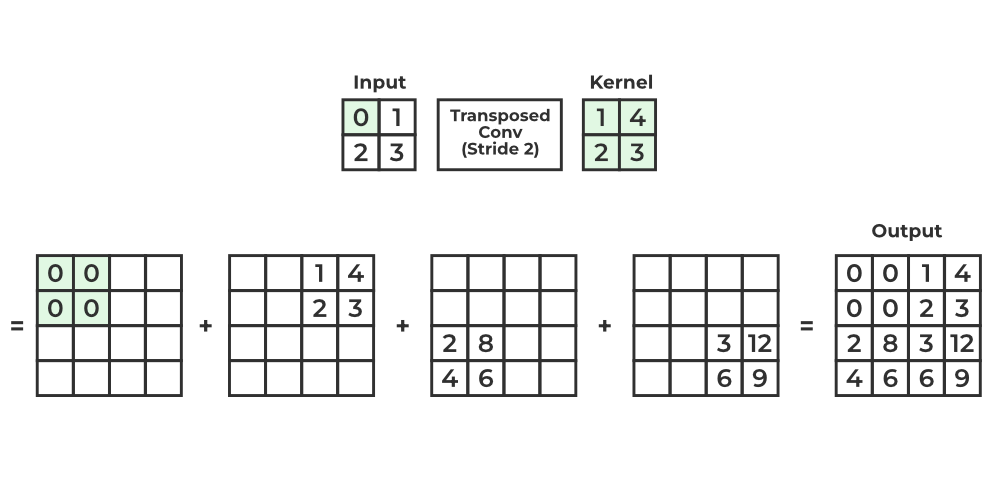

## Exercício 2

* Agora com sua arquitetura `DeconvNet` definida, crie um objeto especificando corretamente o número de canais de entrada e o número de classes.
* Instancie a função de custo baseada em entropia cruzada, podendo ser a `torch.nn.CrossEntropyLoss` ou sua versão modificada para segmentação `CrossEntropyLoss` definida abaixo. Varie entre `reduction=sum` ou `reduction=mean` e veja a diferença durante o treinamento.
* Instancie seu otimizador, escolhendo entre `torch.optim.Adam` ou `torch.optim.SGD`. Fique atento quanto aos parâmetros de cada um.

In [13]:
#@title Criando rede DeconvNet

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# TODO: definir seu modelo
network = ...

In [14]:
#@title Definindo Perca e Otimizador
class CrossEntropyLoss:
    def __init__(self, ignore_index=255, reduction='none', weight=None):
        self.ignore_index = ignore_index
        self.reduction = reduction
        self.weight = weight

    def __call__(self, slices, targets):
        if len(targets.shape) > 3:
            targets = torch.squeeze(targets, dim=1)
        return torch.nn.functional.cross_entropy(slices, targets, ignore_index=self.ignore_index, reduction=self.reduction, weight=self.weight)


# https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
# https://pytorch.org/docs/stable/generated/torch.optim.Adadelta.html
# https://pytorch.org/docs/stable/generated/torch.optim.Adam.html
# https://pytorch.org/docs/stable/generated/torch.optim.SGD.html
# TODO: definir sua perda e otimizador
criterion = ...
optimizer = ...

## Treinamento e Validação

In [15]:
#@title Definindo Métricas
class RunningScore:
    def __init__(self, n_classes):
        self.confusion_matrix = torch.zeros((n_classes, n_classes))
        self.n_classes = n_classes

    def __compute_matrix(self, label_true, label_pred, n_class):
        mask = (label_true >= 0) & (label_true < n_class)
        hist = torch.bincount(n_class * label_true[mask].to(int) + label_pred[mask], minlength=n_class**2).reshape(n_class, n_class)
        return hist.cpu()

    def update(self, slices, targets):
        label_preds, label_trues = slices.detach().max(dim=1)[1], targets.detach()
        for lp, lt in zip(label_preds, label_trues):
            self.confusion_matrix += self.__compute_matrix(lt.flatten(), lp.flatten(), self.n_classes)

    def get_scores(self, epoch=None):
        """
        Returns accuracy score evaluation result.
            - overall accuracy
            - mean accuracy
            - mean IU
        """
        hist = self.confusion_matrix
        acc = torch.diag(hist).sum() / hist.sum()
        acc_cls = torch.diag(hist) / hist.sum(dim=1)
        mean_acc_cls = torch.nanmean(acc_cls)
        iu = torch.diag(hist) / (hist.sum(dim=0) + hist.sum(dim=1) - torch.diag(hist))
        mean_iu = torch.nanmean(iu)
        cls_iu = dict(zip(range(self.n_classes), iu))
        return {'Pixel Acc': acc.item(),
                'Class Accuracy': acc_cls.tolist(),
                'Mean Class Acc': mean_acc_cls.item(),
                'Mean IoU': mean_iu.item(),
                'Confusion Matrix': self.confusion_matrix.tolist()}

    def reset(self):
        self.confusion_matrix = torch.zeros(size=(self.n_classes, self.n_classes))

In [16]:
#@title Treino em uma única época
def train_single_epoch(train_dataloader, criterion, optimizer, network, device='cpu', metrics=None):
    statistics, training_loss = None, 0.

    network.train()
    for batch, (images, labels) in enumerate(train_dataloader):
        optimizer.zero_grad()

        images, labels = images.to(device), labels.to(device)
        outputs = network(images)

        if metrics is not None:
            metrics.update(slices=outputs, targets=labels)

        loss = criterion(slices=outputs, targets=labels)
        training_loss += loss.item() / len(images)
        loss.backward()
        optimizer.step()

        # print segmentation on training data
        print(f'TRAINING - Batch: {batch + 1} | Loss: {training_loss / (batch + 1)}')

        # display segmentation on training data
        out_figure = {
            'Image': images[0].detach().cpu().numpy().squeeze(),
            'Preds': train_dataloader.dataset.decode_segmap(outputs[0].detach().cpu().argmax(dim=0).numpy()),
            'Label': train_dataloader.dataset.decode_segmap(labels[0].detach().cpu().numpy().squeeze())
        }
        figure, axes = plt.subplots(1, 3, figsize=(12, 3))
        for axis,(segname,segmap) in zip(axes, out_figure.items()):
            axis.set_title(segname)
            axis.imshow(segmap)
        plt.show()
        plt.close()

        if (batch + 1) % 5 == 0:
            break

    # reset epoch statistics
    if metrics is not None:
        statistics = metrics.get_scores()
        metrics.reset()

    return network, statistics

In [ ]:
training_score = RunningScore(n_classes=train_dataset.n_classes)
network, statistics = train_single_epoch(train_dataloader, criterion, optimizer, network, device=device, metrics=training_score)

print('Statistics')
for key, value in statistics.items():
    print(f'\t{key}: {value}')

## Exercício 3

Dado que você tem o treinamento em uma única época na célula acima, implemente uma função que realize o treinamento e a validação, de acordo com os parâmetros abaixo:
* `train_dataloader`: gerenciador de dados do subconjunto de treinamento
* `valid_dataloader`: gerenciador de dados do subconjunto de validação
* `criterion`: função de custo
* `optimizer`: otimizador
* `network`: modelo contendo a arquitetura escolhida
* `device`: dispositivo onde o modelo será treinado (cpu ou cuda)
* `num_epochs`: número de épocas durante o treinamento
* `visual`: parâmetro boleano indicando exibição dos gráficos

In [18]:
#@title Definindo Treino e Validação
def train_valid_stage(train_dataloader, valid_dataloader, criterion, optimizer, network, device='cpu', num_epochs=10, visual=False):
    # TODO: implementar treino e validação
    pass

In [ ]:
network, statistics = train_valid_stage(train_dataloader, valid_dataloader, criterion, optimizer, network, device=device, num_epochs=5, visual=True)

## Data Augmentation

Data augmentation é uma técnica usada para aumentar a quantidade e diversidade de dados de treinamento em aprendizado de máquina, principalmente no caso de imagens.  Imagine que você tem um número limitado de imagens para treinar seu modelo de reconhecimento facial. Através da data augmentation, você cria variações artificiais dessas imagens originais para "enganar" o modelo e torná-lo mais robusto.

Veja como funciona:
* Aplicando transformações geométricas: Você pode rotacionar, escalar, recortar e aplicar espelhamento nas imagens originais. Por exemplo, rotacionar uma imagem de rosto ligeiramente para a esquerda ou direita cria uma nova imagem que o modelo nunca viu antes, mas que ainda representa um rosto.
* Ajustando o brilho e contraste: Aumentando ou diminuindo o brilho e contraste das imagens, simula diferentes condições de iluminação nas quais o modelo pode precisar funcionar.
* Simulando oclusões: Introduzindo pequenas obstruções aleatórias nas imagens, como óculos escuros ou cabelo na frente do rosto, o modelo aprende a lidar com situações do mundo real onde a visão pode ser parcialmente bloqueada.

Veja alguns benefícios do data augmentation:
* Evita overfitting: Quando um modelo treina somente em dados muito específicos, ele pode se tornar muito bom em identificar aqueles dados, mas ter um péssimo desempenho em dados ligeiramente diferentes. A data augmentation ajuda a prevenir isso, expondo o modelo a uma maior variedade de cenários.
* Melhora a generalização: O objetivo final é que o modelo funcione bem em dados novos e nunca vistos antes. A data augmentation ajuda o modelo a aprender características gerais que se aplicam a um tipo de dado, em vez de memorizar detalhes específicos dos dados de treinamento.
* Reduz a necessidade de coleta de dados: Coletar grandes quantidades de dados rotulados pode ser caro e demorado. A data augmentation permite que você aproveite ao máximo os dados que já possui.



In [20]:
# https://pytorch.org/vision/0.9/transforms.html

class Compose(object):
    def __init__(self, augmentations):
        self.augmentations = augmentations

    def __call__(self, img, mask):
        mask = PIL.Image.fromarray(mask, mode='L')
        if len(img.shape) == 2:
            img = PIL.Image.fromarray(img, mode=None)
            assert img.size == mask.size
            for a in self.augmentations:
                img, mask = a(img, mask)
            return numpy.array(img), numpy.array(mask, dtype=numpy.uint8)
        elif len(img.shape) == 3:
            img = PIL.Image.fromarray(img.transpose(1,2,0), mode='RGB')
            assert img.size == mask.size
            for a in self.augmentations:
                img, mask = a(img, mask)
            return numpy.array(img).transpose(2,0,1), numpy.array(mask, dtype=numpy.uint8)
        else:
            raise RuntimeError(f'There is no implementation for image dimension {img.shape}')


class AddNoise(object):
    def __call__(self, img, mask):
        if img.im.bands == 1:
            noise = numpy.random.normal(loc=0,scale=0.02,size=(img.size[1], img.size[0]))
        else:
            noise = numpy.random.normal(loc=0,scale=0.02,size=(img.size[1], img.size[0], img.im.bands))
        return img + noise, mask


class RandomRotate(object):
    def __init__(self, degree=5.):
        self.degree = degree
        # self.counter = 0

    def __call__(self, img, mask):
        '''
        PIL automatically adds zeros to the borders of images that rotated. To fix this
        issue, the code in the botton sets anywhere in the labels (mask) that is zero to
        255 (the value used for ignore_index).
        '''
        rotate_degree = random.random() * 2 * self.degree - self.degree

        img = img.rotate(rotate_degree, PIL.Image.BILINEAR)
        mask =  mask.rotate(rotate_degree, PIL.Image.NEAREST)

        binary_mask = PIL.Image.fromarray(numpy.ones([mask.size[1], mask.size[0]]))
        binary_mask = binary_mask.rotate(rotate_degree, PIL.Image.NEAREST)
        binary_mask = numpy.array(binary_mask)

        mask_arr = numpy.array(mask)
        mask_arr[binary_mask==0] = 255
        mask = PIL.Image.fromarray(mask_arr)

        return img, mask


class RandomVerticallyFlip(object):
    def __call__(self, img, mask):
        if random.random() < 0.5:
            return img.transpose(PIL.Image.FLIP_LEFT_RIGHT), mask.transpose(PIL.Image.FLIP_LEFT_RIGHT)
        return img, mask

## Exercício 4

Retreine sua rede utilizando *data augmentation* e o otimizador `torch.optim.Adam`.

Houve alguma mudança nos resultados? E no tempo de convergência da rede?

In [21]:
# TODO: definir datasets com transformações
data_aug = ...

train_dataset = ...
valid_dataset = ...

train_dataloader = ...
valid_dataloader = ...

In [ ]:
# TODO: definir modelo, perda e otimizador
network = ...
criterion = ...
optimizer = ...

torch.cuda.empty_cache()

network, statistics = train_valid_stage(train_dataloader, valid_dataloader, criterion, optimizer, network, device=device, num_epochs=5, visual=True)

## Desafio

Até agora, você implementou o treinamento e validação utilizando exclusivamente o bloco de treinamento. Está na hora de verificar a acurácia de seu método nos conjuntos de testes. Entretanto, desta vez, você poderá utilizar artifícios como data augmentation e, até mesmo, três canais na entrada de sua rede.

Implemente a predição em um dos conjuntos de teste da base de dados *F3 Block* (*test1* ou *test2*).